In [1]:
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import prim
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import MultiprocessingEvaluator, ema_logging
import pickle

In [2]:
model, _ = get_model_for_problem_formulation(2)

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000 #In assignment 5 is at first 1000 used and later on for the dimensional stacking 10000. 
n_policies = 8 #Not sure if we have to go for 8 again here like in the earlier exploratory modeling

use_pickle1 = True
if use_pickle1:
    with open('data/PRIM_results1.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, n_policies)
    
    with open('data/PRIM_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)

In [4]:
experiments, outcomes = results

In [5]:
cleaned_experiments = experiments.drop(labels=[l.name for l in model.levers], axis=1)
## Waarom worden de policies er hier uit gehaald

In [6]:
import numpy as np

data = outcomes['Expected Number of Deaths']
y = data < np.percentile(data, 95) #Not sure which percentile we need to use

In [7]:
#threshold (float) – the density threshold that a box has to meet
#Not sure which tresholds we need to use?
prim_alg = prim.Prim(cleaned_experiments,y, threshold=0.8, peel_alpha=0.05) 
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 8000 points remaining, containing 7600 cases of interest
C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\analysis\prim.py:742: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.peeling_trajectory = self.peeling_trajectory.append(
C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\analysis\prim.py:742: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.peeling_trajectory = self.peeling_trajectory.append(
C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\analysis\prim.py:742: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.peeling_trajectory = self.peeling_trajectory.append(
C:\Users\Thomas\minicond

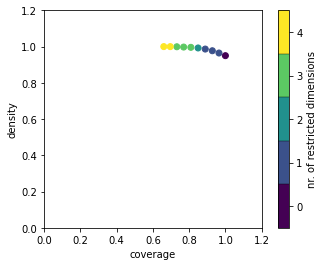

In [8]:
box1.show_tradeoff()
plt.show()

coverage     0.66
density       1.0
id              9
mass        0.627
mean          1.0
res_dim         4
Name: 9, dtype: object

              box 9                                          
                min       max                       qp values
A.3_pfail  0.225168  0.999841   [2.507113327463561e-83, -1.0]
A.2_pfail  0.104847  0.999787  [6.1880947198188274e-18, -1.0]
A.5_pfail  0.047927  0.999627   [1.015471553801142e-07, -1.0]
A.1_pfail  0.045264  0.999009    [0.022338578417480895, -1.0]



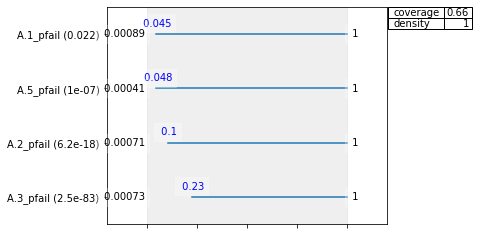

In [9]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [10]:
from ema_workbench.analysis import dimensional_stacking

[MainProcess/INFO] model dropped from analysis because only a single category


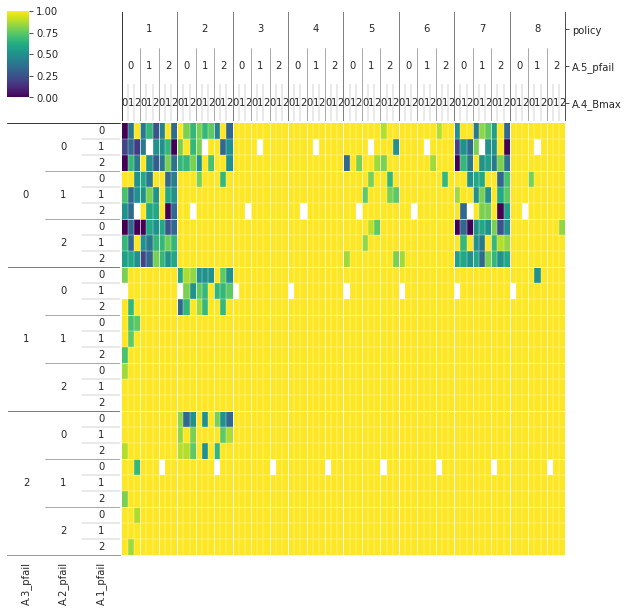

In [11]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)
plt.show()